## Steady-state simulation

In [5]:
from reframed import Community, Environment
from reframed import load_cbmodel, FBA, plot_flux_envelope

# load model
MRA = load_cbmodel("../GEMs/MRA.xml", flavor="bigg")

# impose constraints on SALA reactions so that the model cannot go crazy with the loop
MRA.reactions.R_HPPHD.set_flux_bounds(0, float("inf"))
MRA.reactions.R_DHPPSA.set_flux_bounds(0, float("inf"))
MRA.reactions.R_DLDH.set_flux_bounds(float("-inf"), 0)
MRA.reactions.R_HPLSA.set_flux_bounds(0, float("inf"))

# build "community"
community = Community('RA_community', [MRA])
merged_community = community.merge_models()

# get medium
CAL2 = load_cbmodel("../GEMs/CAL2.xml", flavor="bigg")
medium = Environment.from_model(CAL2).apply(merged_community, exclusive=True, inplace=False)

/Users/andreastallvik/Projects/BIOTBT3900/venv/lib/python3.10/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_34dhcinm_e
  warn(f'Exchange reaction not in model: {r_id}')


In [6]:
import updated_steadycom

sc_com_som = updated_steadycom.SteadyCom(community, constraints=medium, objective="R_EX_rosma_e")
print("RA production rate: ", sc_com_som.values["R_EX_rosma_e"])

RA production rate:  0.0013122903878769188


## Dynamic simulation

### compare to monoculture

In [1]:
from dfba_comets import run_dfba_for_monoculture
import matplotlib.pyplot as plt
import seaborn as sns

sim = run_dfba_for_monoculture()


Running COMETS simulation ...
Done!


In [6]:
print("Total biomass g(DW):", sum(sim.total_biomass.drop(columns=["cycle"], inplace=False).iloc[-1]))
print("Total RA produced (mmol): ", sim.get_metabolite_time_series()["rosma_e"].iloc[-1])

Total biomass g(DW): 0.23809296349
Total RA produced (mmol):  0.00069348987944


### Different inocculation ratios and gluxose / xylose ratios

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("all_exp_results_hLB")

In [3]:
# add the two dud experiments (for default RA_lb)
df = pd.concat([df, 
           pd.DataFrame([{"inoculation_ratio": "(2, 1, 1)", "glc_xyl_ratio":"(1, 4)", "total_biomass": 0, "total_RA": 0}]),
           pd.DataFrame([{"inoculation_ratio": "(3, 1, 1)", "glc_xyl_ratio":"(1, 4)", "total_biomass": 0, "total_RA": 0}])
           ], axis=0, ignore_index=True)

In [27]:
def mmol_to_mg_L(mmol):
    MM_RA = 360.3148
    mg = mmol*MM_RA
    mg_L = mg/0.1
    return mg_L

In [28]:
df["RA_concentration"] = mmol_to_mg_L(df["total_RA"])

In [29]:
fig_A = df[df["glc_xyl_ratio"] == "(1, 4)"]
fig_B = df[df["glc_xyl_ratio"] == "(2, 3)"]
fig_C = df[df["glc_xyl_ratio"] == "(3, 2)"]
fig_D = df[df["glc_xyl_ratio"] == "(4, 1)"]

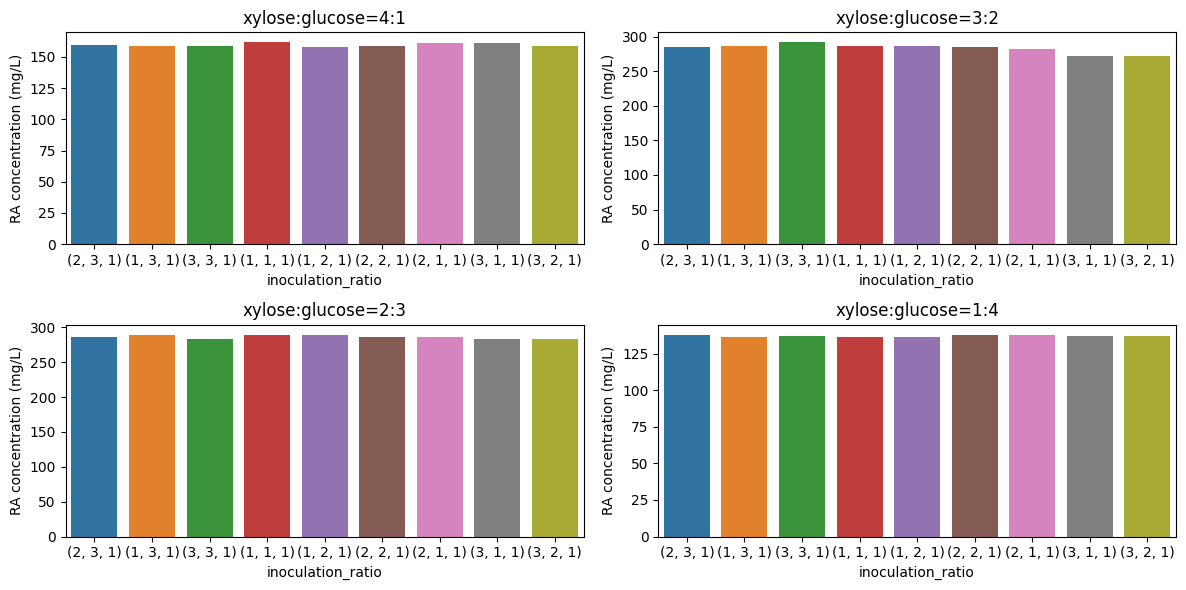

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

sns.barplot(data=fig_A, x="inoculation_ratio", y="RA_concentration", ax=axes[0, 0])
axes[0, 0].set_title('xylose:glucose=4:1')

sns.barplot(data=fig_B, x="inoculation_ratio", y="RA_concentration", ax=axes[0, 1])
axes[0, 1].set_title('xylose:glucose=3:2')

sns.barplot(data=fig_C, x="inoculation_ratio", y="RA_concentration", ax=axes[1, 0])
axes[1, 0].set_title('xylose:glucose=2:3')

sns.barplot(data=fig_D, x="inoculation_ratio", y="RA_concentration", ax=axes[1, 1])
axes[1, 1].set_title('xylose:glucose=1:4')

for ax in axes.flat:
    ax.set_ylabel('RA concentration (mg/L)')

plt.tight_layout()

plt.show()

In [31]:
print("The highest RA production with the combination:\n", df.loc[df['RA_concentration'].idxmax()])

The highest RA production with the combination:
 inoculation_ratio     (3, 3, 1)
glc_xyl_ratio            (2, 3)
total_biomass          0.165741
total_RA               0.080928
RA_concentration     291.596445
Name: 9, dtype: object
